## Baro Array - Animation

### Importing

In [1]:
import os
import gc
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pandas as pd

from obspy.clients.fdsn import Client, RoutingClient
from obspy.signal.array_analysis import array_transff_wavenumber
from obspy.imaging.cm import obspy_sequential
from obspy.geodetics import locations2degrees

from andbro__querrySeismoData import __querrySeismoData

In [2]:
from functions.read_DEM import __read_DEM

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [4]:
# import elevation

# !eio clip -o ROMY_30m_DEM.tif --bounds 11.2 48.1 11.3 48.2

In [5]:
dem = __read_DEM("ROMY_30m_DEM.tif")

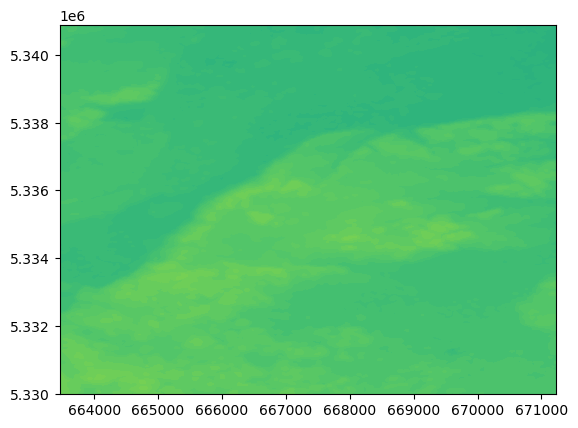

In [6]:
plt.contourf(dem['utm_e'],
             dem['utm_n'],
             dem['data'],
             cmap="viridis",
             levels=list(range(0, 800, 10))
             )

### Setting Variables

In [7]:
config = {}

config['klim'] = 50.
config['kstep'] = config['klim'] / 100.

config['tbeg'] = obspy.UTCDateTime("2024-03-16 13:00")
config['tend'] = obspy.UTCDateTime("2024-03-16 14:00")


config['seeds'] = [
                   'BW.GELB..LDO',
                   'BW.GRMB..LDO',
                   'BW.ALFT..LDO',
                   'BW.BIB..LDO',
                   'BW.TON..LDO',
                   'BW.ROMY..LDI',
]

config['fmin'] = 0.005
config['fmax'] = 0.05

config['path_to_figs'] = data_path+"/LNM2/figures/"

config['ref_station'] = 'BW.ROMY..HH*'

config['client'] = RoutingClient("eida-routing")

### Defining Methods

In [8]:
def __get_array_stations(seeds, tbeg, tend):

    route =  RoutingClient("eida-routing")

    for _i, seed in enumerate(seeds):

        net, sta, loc, cha = seed.split(".")


        inv =route.get_stations(
                                network=net,
                                station=sta,
                                channel="*",
                                starttime=tbeg,
                                endtime=tend,
                                # latitude=ref_coords[0],
                                # longitude=ref_coords[1],
                                # minradius=0,
                                # maxradius=max_radius,
                            )
        if _i == 0:
            invs = inv
        else:
            invs += inv

    # inv_check.plot(projection="local");

    codes, lon, lat, elev = [], [], [], []
    for h, network in enumerate(invs):
        for i, station in enumerate(network):

            codes.append(f'{invs[h].code}.{station.code}')
            lon.append(station.longitude)
            lat.append(station.latitude)
            elev.append(station.elevation/1000.)

    # create dataframe
    frame = pd.DataFrame({'codes': codes, 'lon': lon, 'lat': lat, 'elev': elev})

    # sort the dataframe
    frame.sort_values(by="codes", inplace=True)

    frame.reset_index(inplace=True, drop=True)

    return frame

In [9]:
array_stations = __get_array_stations(config['seeds'], config['tbeg'], config['tend'])

In [10]:
array_stations

,codes,lon,lat,elev
0,BW.ALFT,11.279500,48.142334,0.593
1,BW.BIB,11.247300,48.152200,0.599
2,BW.GELB,11.251400,48.162900,0.628
3,BW.GRMB,11.263500,48.140600,0.656
4,BW.ROMY,11.275476,48.162941,0.571
5,BW.TON,11.288809,48.173897,0.564


In [11]:
def __array_latlon_to_xyz(array_stations, ref_station="GR.FUR"):
    """Convert angluar to cartesian coordiantes

    latitude is the 90deg - zenith angle in range [-90;90]
    lonitude is the azimuthal angle in range [-180;180] 
    """

    from numpy import zeros
    import utm

    # modify ref_station
    net, sta, loc, cha = ref_station.split(".")
    ref_station = f"{net}.{sta}"

    if ref_station not in list(array_stations.codes):
        print(f"-> {ref_station} not vaild")
        return


    for _i in ["x_m", "y_m", "z_m", "utm_n", "utm_e", "utm_zone", "utm_letter"]:
        array_stations[_i] = zeros(array_stations.shape[0])

    sta_ref = array_stations[array_stations.codes == ref_station]
    utm_ref_e, utm_ref_n, utm_zone, utm_letter = utm.from_latlon(sta_ref.lat.iloc[0], sta_ref.lon.iloc[0])
    z_ref = sta_ref.elev.iloc[0]

    for i, sta in array_stations.iterrows():

        utm_e, utm_n, utm_zone, utm_letter = utm.from_latlon(sta.lat, sta.lon)

        array_stations.loc[i, "utm_n"] = utm_n
        array_stations.loc[i, "utm_e"] = utm_e
        array_stations.loc[i, "x_m"] = round(( utm_e - utm_ref_e ), 2)
        array_stations.loc[i, "y_m"] = round(( utm_n - utm_ref_n ), 2)
        array_stations.loc[i, "z_m"] = ( array_stations.loc[i, "elev"] - z_ref ) * 1e3

        array_stations.loc[i, "utm_zone"] = utm_zone
        array_stations.loc[i, "utm_letter"] = str(utm_letter)

    array_stations["x_km"] = array_stations["x_m"] / 1000
    array_stations["y_km"] = array_stations["y_m"] / 1000
    array_stations["z_km"] = array_stations["z_m"] / 1000

    return array_stations

In [12]:
array_stations = __array_latlon_to_xyz(array_stations, ref_station=config['ref_station'])

In [13]:
def __calculate_distance_of_stations(array_stations, output="km", ref_station=None):
    '''
    from obspy.geodetics import locations2degrees

    '''

    from numpy import round

    N = len(array_stations)

    # modify ref_station
    if ref_station is not None:
        net, sta, loc, cha = ref_station.split(".")
        ref_station = f"{net}.{sta}"

    if ref_station is not None:
        dist_in_deg = {}
        station1 = array_stations[array_stations.codes == ref_station]
        lat1, lon1 = station1.lat, station1.lon
        for j, station2 in array_stations.iterrows():
            name = str(station2.codes)
            _dist= locations2degrees(lat1  = lat1,
                                      long1 = lon1,
                                      lat2  = station2[2],
                                      long2 = station2[1],
                                      )
            if output == "km":
                dist_in_deg[name] = round(_dist[0]*111, decimals=2)
            elif output == "deg":
                dist_in_deg[name] = round(_dist[0], decimals=2)

    else:
        dist_in_deg = np.zeros((N, N))
        for i, station1 in array_stations.iterrows():
            for j, station2 in array_stations.iterrows():
                 _dist = locations2degrees(lat1  = station1[2],
                                          long1 = station1[1],
                                          lat2  = station2[2],
                                          long2 = station2[1],
                                          )
            if output == "km":
                dist_in_deg[i][j] = round(_dist*111, decimals=4)
            elif output == "deg":
                dist_in_deg[i][j] = round(_dist, decimals=4)

    return dist_in_deg

## Compute station distance

In [14]:
distances = __calculate_distance_of_stations(array_stations, output="km", ref_station=config['ref_station'])
distances

{'BW.ALFT': 2.31,
 'BW.BIB': 2.4,
 'BW.GELB': 1.78,
 'BW.GRMB': 2.63,
 'BW.ROMY': 0.0,
 'BW.TON': 1.57}

In [15]:
cross_distances = __calculate_distance_of_stations(array_stations, output="km", ref_station=None)
cross_distances

array([[0.    , 0.    , 0.    , 0.    , 0.    , 3.5707],
       [0.    , 0.    , 0.    , 0.    , 0.    , 3.9045],
       [0.    , 0.    , 0.    , 0.    , 0.    , 3.0265],
       [0.    , 0.    , 0.    , 0.    , 0.    , 4.1439],
       [0.    , 0.    , 0.    , 0.    , 0.    , 1.5663],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]])

### Calulcate Distances, Plot Array Geometry and Response

In [16]:
def __plot_array_geometry_and_response(array, transff, klim, kstep, names=None, unit=None):

    import numpy as np

    # calulcate geometrical center of array
    array_center = [np.median(array[:, 0]), np.median(array[:, 1])]

    # find geometrical limits of array
    lon_min, lon_max = np.min(array[:, 0]), np.max(array[:, 0])
    lat_min, lat_max = np.min(array[:, 1]), np.max(array[:, 1])

    # define bounds
    kxmin, kxmax, kymin, kymax = -klim, klim, -klim, klim


    # _________________________________________________________
    #
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    fs=12

    if unit == "km":
        xdata = (array[:, 0]-array_center[0])*111.
        ydata = (array[:, 1]-array_center[1])*111. * np.cos(array[:, 1]/180.*np.pi)
        x0, y0 = array_center[0]*111., array_center[1]*111. * np.cos(array[1]/180.*np.pi)

    elif unit == "deg":
        xdata = array[:, 0]
        ydata = array[:, 1]
        x0, y0 = array_center[0], array_center[1]

    # plot digital elevation model
    axes[0].contourf(dem['longitude'],
                     dem['latitude'],
                     dem['data'],
                     cmap="gray",
                     levels=list(range(400, 650, 2))
                     )

    # axes[0].contour(dem['longitude'],
    #                 dem['latitude'],
    #                 dem['data'],
    #                 colors='k',
    #                 lw=0.1,
    #                 levels=list(range(400, 700, 10))
    #                 )

    # ________________________________________________
    axes[0].scatter(xdata, ydata, s=35, color='black', marker='v', zorder=3)
    axes[0].scatter(x0, y0, color='red', marker='o', s=25, zorder=2)

    if unit == "km" or unit is None:
        axes[0].set_xlabel('X (km)', fontsize=fs)
        axes[0].set_ylabel('Y (km)', fontsize=fs)

        axes[0].set_ylim([-max(abs(ydata))*0.99, max(abs(ydata))*1.01])
        axes[0].set_xlim([-max(abs(xdata))*0.99, max(abs(xdata))*1.01])

    elif unit == "deg":
        axes[0].set_xlabel('Longitude (°)', fontsize=fs)
        axes[0].set_ylabel('Latitude (°)', fontsize=fs)

        axes[0].set_ylim([min(abs(ydata))*0.9999, max(abs(ydata))*1.0001])
        axes[0].set_xlim([min(abs(xdata))*0.999, max(abs(xdata))*1.001])

    axes[0].set_title('Array Stations', fontsize=fs+2)

    for x, y, s in zip(xdata, ydata, list(names)):
        axes[0].text(x+.001, y+.0, s, ha="left", va="top")

    # ________________________________________________
    ax2 = axes[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
                         np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
                         transff.T, cmap=obspy_sequential,
                        )

    plt.colorbar(ax2, ax=axes[:])
    ax2.set_clim(0., 1.)

    axes[1].set_xlim(kxmin, kxmax)
    axes[1].set_ylim(kymin, kymax)
    axes[1].set_xlabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_ylabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_title('Array Response Function', fontsize=fs+2)

    plt.show();

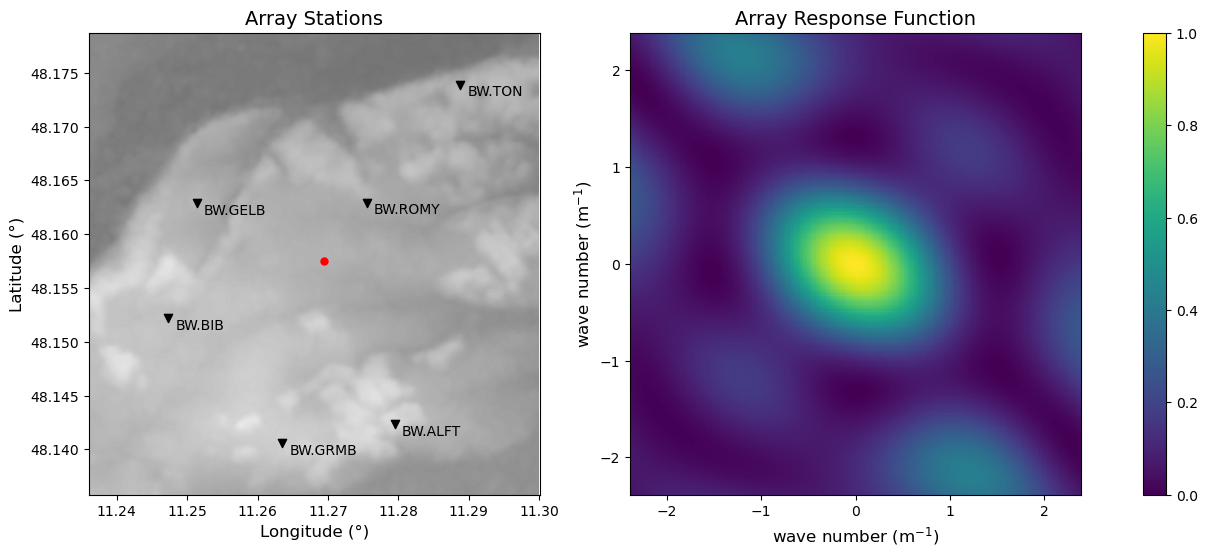

In [17]:
# get maximal distance
dist_max = max(distances.values())

lambda_min = 1*dist_max # in km

config['k_max'] = 2*np.pi/lambda_min
config['k_step'] = config['k_max'] / 100.

coordinates = np.column_stack([array_stations.lon, array_stations.lat, array_stations.elev])

# compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(coordinates,
                                   config['k_max'],
                                   config['k_step'],
                                   coordsys='lonlat'
                                   )


__plot_array_geometry_and_response(coordinates,
                                   transff,
                                   config['k_max'],
                                   config['k_step'],
                                   array_stations.codes,
                                   unit="deg",
                                  )


In [18]:
for i, array_station in array_stations.iterrows():

    # adjustment for ROMY pressure
    if "ROMY" in array_station.codes:
        array_stations.codes.iloc[i] = "BW.PROMY"


/tmp/ipykernel_787324/2492493264.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  array_stations.codes.iloc[i] = "BW.PROMY"


### Load FURT Data

In [19]:
from andbro__load_FURT_stream import __load_furt_stream

In [20]:
furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

/home/andbro/andbro_python/andbro__load_FURT_stream.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = to_datetime(df['datetime'], format="%d%m%y %H%M%S", errors="ignore")


### Load Pressure Data

In [21]:
from andbro__read_sds import __read_sds

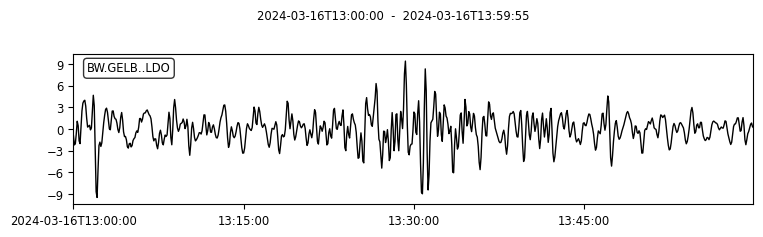

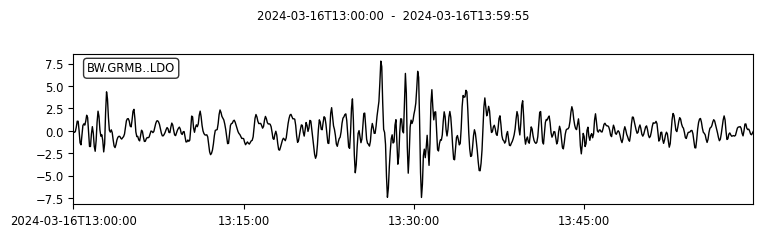

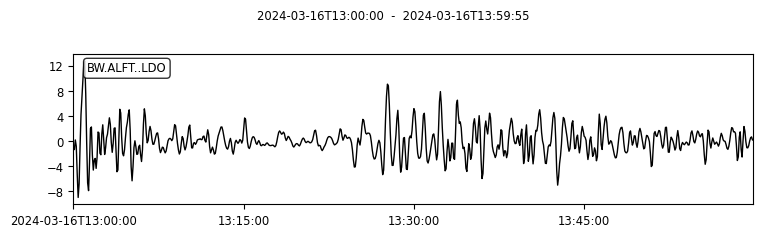

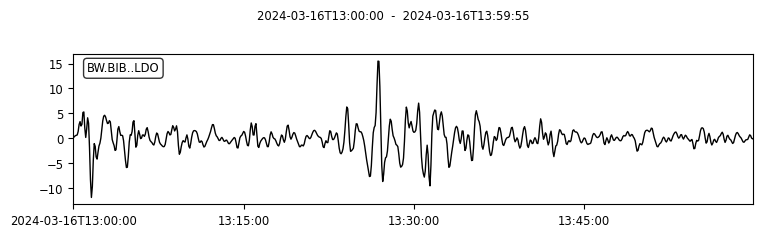

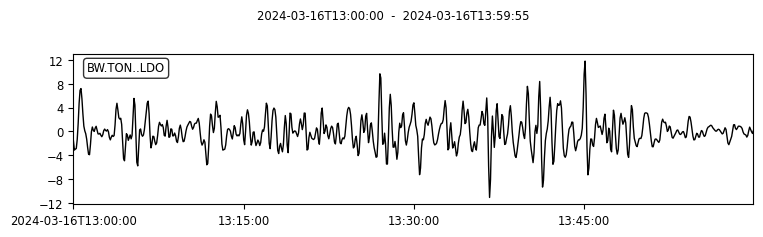

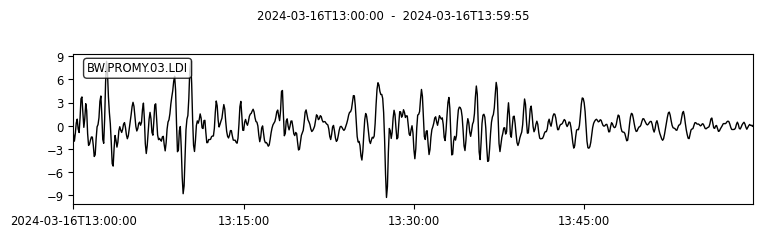

In [22]:
df_pressure = pd.DataFrame()

for _i, seed in enumerate(config['seeds']):

    if "ROMY" in seed:
        seed = "BW.PROMY.03.LDI"

    ps = __read_sds(archive_path+"temp_archive/", seed, config['tbeg'], config['tend'])

    # convert from Pa to hPa
    if "ROMY" in seed:
        ps[0].data = ps[0].data / 100

    ps = ps.detrend("simple")

    ps = ps.taper(0.01, type="cosine")

    ps = ps.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

    ps = ps.resample(config['fmax']*4)

    # convert from hPa to Pa
    ps[0].data = ps[0].data * 100

    if _i == 0:
        df_pressure["time"] = ps[0].times(reftime=config['tbeg'])

    df_pressure[f"{seed.split('.')[0]}.{seed.split('.')[1]}"] = ps[0].data

    ps.plot();

In [23]:
df_pressure.shape[0]

720

### Plot Animation

In [24]:
def __gradient_grid(frame):

    from scipy.interpolate import griddata

    dx, dy = 0.250, 0.250

    xx, yy = array_stations.x_km, array_stations.y_km

    grid_x, grid_y = np.mgrid[min(xx)*1.2:max(xx)*1.2:dx, min(yy)*1.2:max(yy)*1.2:dy]

    points, values = [], []
    for i, sta in enumerate(df_pressure.keys()):
        if sta == "time":
            continue

        _x = array_stations[array_stations.codes == sta].x_km.iloc[0]
        _y = array_stations[array_stations.codes == sta].y_km.iloc[0]

        points.append([_x, _y])
        values.append(df_pressure[sta].iloc[frame])

    grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

    return grid_x, grid_y, grid_z

In [ ]:
def __makeplot_barometer_array():

    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from matplotlib.gridspec import GridSpec
    from functions.smoothing import __smooth
    from functions.interpolate_nan import __interpolate_nan


    ref_station = "BW.PROMY"

    frames = df_pressure.shape[0]
    frames = 30

    Ncol, Nrow = 1, 6

    maker_size = 100

    p_min, p_max = -2, 2

    time_scaling = 1/60

    font = 12

    fig = plt.figure(figsize=(10, 15))

    # set tight layout
    fig.set_tight_layout(True)

    # adjust space between subplots
    plt.subplots_adjust(hspace=0.3)

    # specify grid of subplots
    gs = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs[1:4, :])
    ax2 = fig.add_subplot(gs[4, :])
    ax3 = fig.add_subplot(gs[5, :])

    ax3_1 = ax3.twinx()

    # _____________________________________
    # ax1.scatter(array_stations.x_m, array_stations.y_m, s=maker_size, edgecolor="k", color="w")


    cmap = plt.get_cmap("coolwarm")

    def init():

        print(f"-> launch animation")


    def update(i):

        if i%10 == 0:
            print(f"{i} ...")

        gx, gy, gz = __gradient_grid(i)

        # clear the axis each frame
        ax1.clear()

        ax1.set_xlabel("East of ROMY (km)", fontsize=font)
        ax1.set_ylabel("North of ROMY (km)", fontsize=font)
        ax1.set_title("Barometric Pressure @ROMY", fontsize=font+1)

        # add topography
        ax1.contourf((dem['utm_e'] - array_stations[array_stations.codes == ref_station].utm_e.iloc[0] ) / 1000,
                     (dem['utm_n'] - array_stations[array_stations.codes == ref_station].utm_n.iloc[0] ) / 1000,
                     dem['data'],
                     cmap="gray",
                     levels=list(range(400, 700, 2)),
                     # rasterized=True,
                     )

        ax1.pcolormesh(gx, gy, gz, alpha=0.5, cmap=cmap, vmin=p_min, vmax=p_max)


        # replot data
        for station in df_pressure.keys():
            if "time" in station:
                continue

            im = ax1.scatter(array_stations[array_stations.codes == station].x_km,
                            array_stations[array_stations.codes == station].y_km,
                            s=maker_size,
                            c=df_pressure[station][i],
                            cmap=cmap,
                            vmin=p_min, vmax=p_max,
                            edgecolor="k",
                           )



        # add label for time
        ax1.text(.1, .95, f"{df_pressure['time'][i]}s", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)

        # add label for stations
        for x, y, s in zip(array_stations.x_km, array_stations.y_km, array_stations.codes):
            ax1.text(x, y-.1, s, ha="left", va="top")

        ax1.set_ylim([min(array_stations.y_km)*1.5, max(array_stations.y_km)*1.5])
        ax1.set_xlim([min(array_stations.x_km)*1.5, max(array_stations.x_km)*1.5])

        # add colorbar
        cbar_ax = fig.add_axes([0.15, 0.4, 0.02, 0.1]) #[left, bottom, width, height]
        cb = plt.colorbar(im, cax=cbar_ax, extend="both")
        cb.set_label("Pressure (Pa)", fontsize=font, labelpad=-48, color="black")


        # _____________________________________
        # update time indicator
        ax2.clear()

        ax2.plot(df_pressure["time"]*time_scaling,
                 df_pressure[ref_station],
                 color="black",
                 label=f"{config['fmin']} - {config['fmax']} Hz",
                )
        # update time indicator
        ax2.axvline(df_pressure["time"][i]*time_scaling,
                    p_min, p_max,
                    color="red",
                   )

        ax2.set_ylabel("Pressure (pa)", fontsize=font)
        ax2.legend(loc=1, fontsize=font-1)

        # _____________________________________
        # update time indicator
        ax3.clear()

        ax3.plot(furt.select(channel="LAW")[0].times(reftime=config['tbeg'])*time_scaling,
                 __smooth(__interpolate_nan(furt.select(channel="LAW")[0].data), 60),
                 color="tab:blue",
                )

        ax3_1.plot(furt.select(channel="LAD")[0].times(reftime=config['tbeg'])*time_scaling,
                   __smooth(__interpolate_nan(furt.select(channel="LAD")[0].data), 60),
                   color="tab:orange",
                  )
        ax3_1.set_ylim(0, 360)

        # update time indicator
        ax3.axvline(df_pressure["time"][i]*time_scaling,
                    p_min, p_max,
                    color="red",
                   )

        ax3.set_ylabel("Wind Speed (m/s)", fontsize=font)
        ax3.set_xlabel("Time (min)", fontsize=font)

        ax3_1.tick_params(axis="y", color="tab:orange")
        ax3_1.set_ylabel("Wind Direction (°)", fontsize=font, color="tab:orange")
        ax3_1.xaxis.label.set_color("tab:orange")

        gc.collect();

    # interval = wait time in ms | repeat = loop after data end
    ani = animation.FuncAnimation(fig, update, init_func=init, frames=frames,
                                  interval=10, repeat=False, repeat_delay=0,
                                  # save_count=0,
                                  cache_frame_data=False,
                                 )
    plt.plot();

    # store animation as gif
    # ani.save('romy_barometer.mp4', writer='moviewriter', dpi=200)
    ani.save(config['path_to_figs']+'romy_barometer_test.mp4',
             writer=animation.FFMpegWriter(fps=30),
             dpi=200,
             # savefig_kwargs={'bbox_inches': 'tight'}
            )

    print(f"-> stored video: romy_barometer_test.mp4")

__makeplot_barometer_array()


-> launch animation
0 ...


/tmp/ipykernel_787324/2044211251.py:68: UserWarning: The following kwargs were not used by contour: 'rasterized'
  ax1.contourf((dem['utm_e'] - array_stations[array_stations.codes == ref_station].utm_e.iloc[0] ) / 1000,
/tmp/ipykernel_787324/2044211251.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ani.save(config['path_to_figs']+'romy_barometer_test.mp4',


10 ...
20 ...
30 ...
40 ...


In [ ]:


from scipy.interpolate import griddata
from time import sleep
from IPython.display import clear_output


for n in range(0, 200):

    dx, dy = 250, 250
    xx, yy = array_stations.x_m, array_stations.y_m

    grid_x, grid_y = np.mgrid[min(xx)*1.2:max(xx)*1.2:dx, min(yy)*1.2:max(yy)*1.2:dy]

    points, values = [], []
    for i, sta in enumerate(df_pressure.keys()):
        if sta == "time":
            continue

        _x = array_stations[array_stations.codes == sta].x_m.iloc[0]
        _y = array_stations[array_stations.codes == sta].y_m.iloc[0]
        points.append([_x, _y])
        values.append(df_pressure[sta].iloc[n])

    grid_z0 = griddata(points, values, (grid_x, grid_y), method='cubic')

    clear_output(wait=True)
    fig = plt.figure()

    plt.pcolormesh(grid_x, grid_y, grid_z0, alpha=0.5)
    plt.scatter(grid_x, grid_y, s=10, marker="x", color="gray")
    plt.scatter(array_stations.x_m, array_stations.y_m, c=values)

    sleep(0.1)
    plt.show()

